# Maxime Nurwubusa _ TP QAOA



## Part 1 implementing QAOA

### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

Comment : 
Let's recall the physical interpretation : "If you imagine that there is a 1/2-spin at each vertex of the graph, then the solution is the
ground state of an Hamiltonian with pairwise anti-ferromagnetic interaction at
each edge."

Once we understand that, it is natural to choose the Hamiltonian that represents the ferromagnetic interaction (Heisenberg/Exchange energy)


### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val=0
    for i,j in edges:
      val=val +(1 if b[i]==b[j] else -1)
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

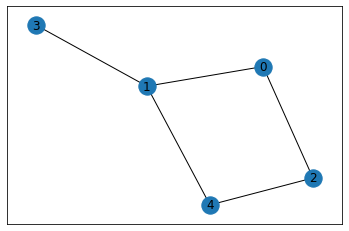

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [7]:
#!pip install wand
#!apt install imagemagick
#!pip install myqlm
#!python -m qat.magics.install
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for k in range(n_qubits):
      layer.apply(RX(theta),k)
    for k,l in edges:
      layer.apply(U_ZZ(beta),k,l)
    
    return layer

### Question 4

In [12]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for k in range(n_qubits):
      prog.apply(H,qubits[k])

    for k in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits,edges,parameters[2*k],parameters[2*k+1]),qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        counting=0 #counting is the contribution
        for i,j in edges:
          counting = counting + (1 if sample.state.bitstring[i]==sample.state.bitstring[j] else -1)
        obs= obs + sample.probability*counting
    # END TODO
    return obs
    
        

In [9]:
import numpy as np
np.random.random(3)

array([0.22316587, 0.48139389, 0.00802278])

In [10]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

0.8681467498172307 -0.6334509016491089 -0.8943354354086044 -0.9802439085141438 -1.466099943958694 -1.509694041509824 -1.592100312849005 -2.2514730123543263 -2.66609082865626 -2.8063875099826054 -2.9725917470267684 -3.0099620021539666 -3.0594296827014014 -3.159659291110295 -3.215526440074881 -3.2815183089263606 -3.3766720336345166 -3.52053516312572 -3.7178580202167666 -3.9691119059360127 -4.10994568824813 -4.152518023109168 -4.203028481959739 -4.237251701921939 -4.251778573547854 -4.254462001376108 -4.2577047789195435 -4.2630806116977435 -4.269999247272631 -4.272820545396884 -4.274064330561233 -4.274957181427793 -4.276511880638976 -4.279053637259787 -4.282274291226011 -4.2843065842314445 -4.2847435867480295 -4.285209462691377 -4.285250047100957 -4.285255453654296 -4.2852566483466505 -4.285256739583425 -4.285256763029343 -4.285256768027926 -4.285256768425523 -2.9094380249678986 -3.9652688801887552 -4.063529994249529 -4.182470304073747 -4.3465972500401335 -4.459642507987148 -4.52958058822

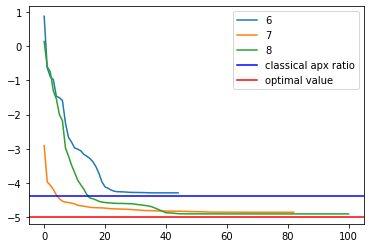

In [13]:
import matplotlib.pylab as plt


for nlayers in range(6,9,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

8 layers are needed for QAOA to reach the optimum value

### Question 6: smart initialization

-1.8530607786758873 -2.0646648674966066 -2.3675649106088534 -2.8757759103486737 -3.1807622701857627 -3.536865546504489 -3.7773847084784857 -3.970437821584704 -3.974932294169126 -3.978229369142069 -3.978268365459454 -3.9782690269931313 -3.978269029653921 -1.4016060998502564 -2.9537639191073417 -3.246376417484305 -3.7700008387386914 -4.069081231913725 -4.304302917875617 -4.3566443496386915 -4.430330272298612 -4.522202204021294 -4.586646600922829 -4.631549346497703 -4.644919708066271 -4.6573114191696705 -4.661343354005026 -4.662357088807134 -4.662578599519375 -4.662589368146721 -4.662589586527569 -4.662589588268692 -4.6625895882885855 -0.9981740929049627 -2.7491651601098033 -3.0680088472222304 -4.298647031282944 -4.497641305536561 -4.537600083543945 -4.5989438200275785 -4.674534020265669 -4.70813980538198 -4.721172141007853 -4.738371799751424 -4.754604262436232 -4.773055892991503 -4.801192385535539 -4.840535308918268 -4.8529821192682485 -4.8630396936336595 -4.875901371961213 -4.8806649402

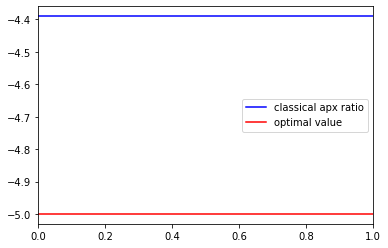

In [15]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(nlayers):
      beta=(k+1)*T/(nlayers**2)
      theta=(1-k-1)*T/(nlayers**2)
      parameters_init.append(theta)
      parameters_init.append(beta)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

I may have done an error for this part.

End.